![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/DICOM_TO_TEXT.ipynb)

# DICOM to Text
Recognize text and extract metada from DICOM format documents.

To run this yourself, you will need to upload your **Spark OCR** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

For more in-depth tutorials: https://github.com/JohnSnowLabs/spark-ocr-workshop/tree/master/jupyter

## 1. Colab Setup

Read licence key

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()
os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Install Dependencies

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

Importing Libraries

In [3]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [1]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
import sparkocr
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources


Start Spark Session

In [4]:
# Start spark
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.9.1



## 2. Download and read DICOM image

download image

In [5]:
!wget https://github.com/JohnSnowLabs/spark-ocr-workshop/raw/master/jupyter/data/dicom/deidentify-medical-1.dcm -O image.dcm

--2022-01-10 17:06:13--  https://github.com/JohnSnowLabs/spark-ocr-workshop/raw/master/jupyter/data/dicom/deidentify-medical-1.dcm
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-1.dcm [following]
--2022-01-10 17:06:14--  https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-1.dcm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640574 (626K) [application/octet-stream]
Saving to: ‘image.dcm’

image.dcm           100%[===================>] 625.56K  --.-KB/s    in 0.

In [6]:
image_df = spark.read.format("binaryFile").load('image.dcm').cache()
image_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/ima...|2022-01-10 17:06:...|640574|[00 00 00 00 00 0...|
+--------------------+--------------------+------+--------------------+



## 3. Construct the OCR pipeline

In [7]:
# Extract images from Dicom format
dicom_to_image = DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setDeIdentifyMetadata(True)

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])


# OCR pipeline
pipeline = PipelineModel(stages=[
    dicom_to_image,
    ocr
])


## 4. Run OCR pipeline

In [8]:
result = pipeline.transform(image_df).cache()

## 5. Visualize Results

Display result dataframe

In [9]:
result.select("text", "confidence").show()

+--------------------+-----------------+
|                text|       confidence|
+--------------------+-----------------+
|OA yer

2018 Oct ...|84.46388498942058|
+--------------------+-----------------+



Display dicom image, extracted text and metadata, and save dicom image as jpg


    Image #0:
    Origin: file:/content/image.dcm
    Resolution: 0 dpi
    Width: 800 px
    Height: 800 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


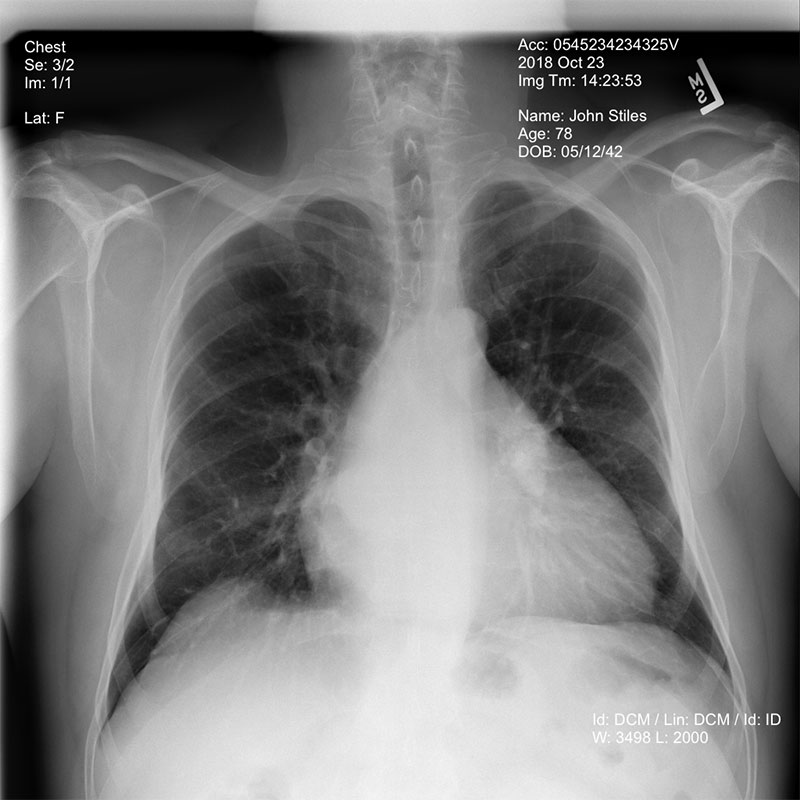

OA yer

2018 Oct 23

Img Tm: 14:23:53
%

Name: John Stiles

 


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.170228217341328822848560557903560820700"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.214240140729127103672606000638950934948"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.3.6.1.4.1.30071.8"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "fo-dicom 4.0.0"
        ]
    },
    "00080020": {
        "vr": "DA"
    },
    "00080050": {
        "vr": "SH"
    },
    "00080080": {
        "vr": "LO",
        "Value": [
            "REMOVED"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
 

In [10]:
for r in result.distinct().collect():
  display_image(r.image_raw)
  print (r.text)
  print (r.metadata)
  img = to_pil_image(r.image_raw, r.image_raw.mode)
  img.save('image.jpg')